#### In this notebook, I used the posts from subreddit nutrition and dietetics and merged them into one dataframe, used CountVectorizer, TfidfVectorizer and Part-of-speech tags to explore the text data.

In [1]:
import pandas as pd  
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag
import re
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Load in two subreddit and merge them into one dataframe

**read in the nutrition subreddit**

In [2]:
nutrition=pd.read_csv('../data/nutrition_subr_raw.csv')

In [3]:
#use only subreddit column and merged title&selftext column

nutrition_df=nutrition.drop(['title','selftext','datetime'],axis=1)

In [4]:
nutrition_df.head(1)

,subreddit,title_text
0,nutrition,Please help me figure out what’s wrong with my...


**read in the dietetics subreddit**

In [5]:
dietetics=pd.read_csv('../data/dietetics_subr_raw.csv')

In [6]:
#use only subreddit column and merged title&selftext column

dietetics_df=dietetics.drop(['title','selftext','datetime'],axis=1)

In [7]:
dietetics_df.head(1)

,subreddit,title_text
0,dietetics,Do you love your job as the dietitian? Will mo...


**merge the two subreddits together**

In [8]:
nut_die=pd.concat([nutrition_df,dietetics_df],ignore_index=True)

In [9]:
#using map to dummify subreddit column: nutrition is 1, dietetics is 0

nut_die['subreddit']=nut_die['subreddit'].map({'nutrition':1,'dietetics':0})

In [10]:
nut_die.head()

,subreddit,title_text
0,1,Please help me figure out what’s wrong with my...
1,1,What Tests For Iron Deficiency? Looking at get...
2,1,How to get protein as a picky eater? [removed]
3,1,Suffering with canker sores [removed]
4,1,Good diets/work outs? I am trying to lose weig...


In [11]:
#find all the null rows

nut_die.isnull().sum()

subreddit      0
title_text    67
dtype: int64

In [12]:
#take a look at some of the rows

nut_die[nut_die.isnull().any(axis=1)]['title_text'].head()

269    NaN
281    NaN
301    NaN
303    NaN
310    NaN
Name: title_text, dtype: object

In [13]:
#find out how many rows that are empty within each subreddits

nut_die.loc[(nut_die['title_text'].isnull()),['subreddit']].value_counts()

subreddit
1            45
0            22
dtype: int64

In [14]:
#drop all the rows with null value

nut_die.dropna(inplace=True)

In [15]:
#check if there is anymore null value after cleaning 

nut_die.isnull().sum()

subreddit     0
title_text    0
dtype: int64

In [16]:
#reset the index

nut_die.reset_index(inplace=True,drop=True)

In [17]:
nut_die.tail()

,subreddit,title_text
3928,0,"Remote learning Education/courses Hey all, I’m..."
3929,0,Non-RD Nutrition Jobs after Graduation [removed]
3930,0,Does anyone have an Inman study guide I could ...
3931,0,Free study resources for RD exam? [removed]
3932,0,Just started my journey to becoming a Register...


---

## Create three new columns: length, word count and sentiment analysis

>**create a new column for the length**

In [18]:
nut_die['nd_length']=[len(sent) for sent in nut_die['title_text']]

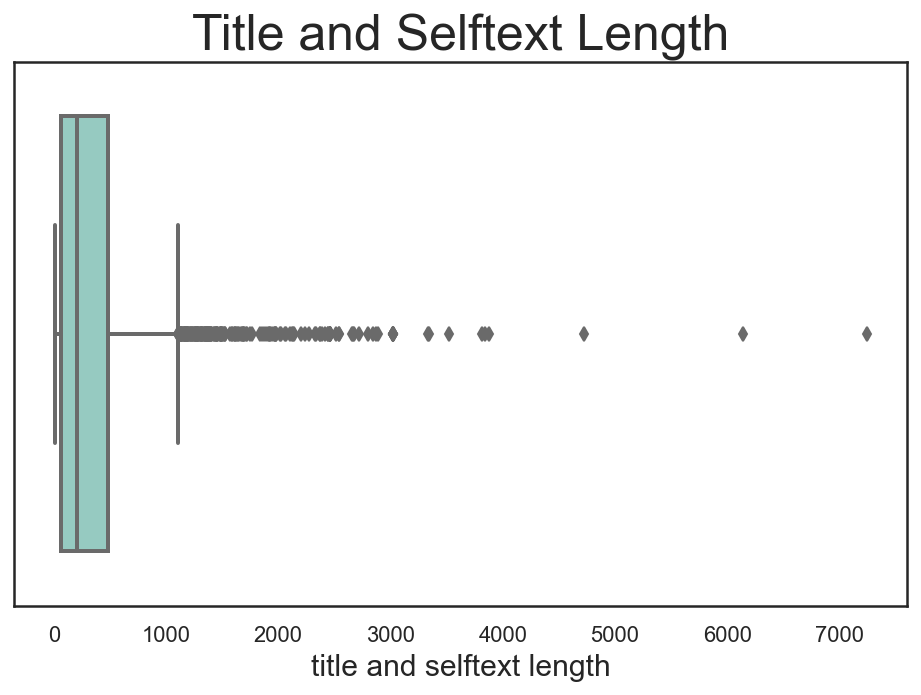

In [19]:
#did a boxplot to find out the outliers

plt.figure(figsize=(8,5))

sns.set_theme(style='white')
sns.boxplot(x=nut_die['nd_length'],palette='Set3', linewidth=2)

plt.title('Title and Selftext Length', size=25)
plt.xlabel('title and selftext length',size=15);

In [20]:
# find out what are the outliers

nut_die.sort_values(by=['nd_length']).tail()

,subreddit,title_text,nd_length
2757,0,Passed RD Exam! + Tips! Hey everyone!\n\nSuper...,3842
2037,0,Diet And Exercising For Weight Loss \n\nObes...,3873
1643,1,It baffles me that while proper nutrition is m...,4726
2560,0,A Week of the Keto Diet: 7-Day Keto Meal Plan ...,6143
3755,0,History of the American Dietetic Association’s...,7241


In [21]:
#drop 3 outliers

nut_die.drop([1643,2560,3755],axis=0,inplace=True)

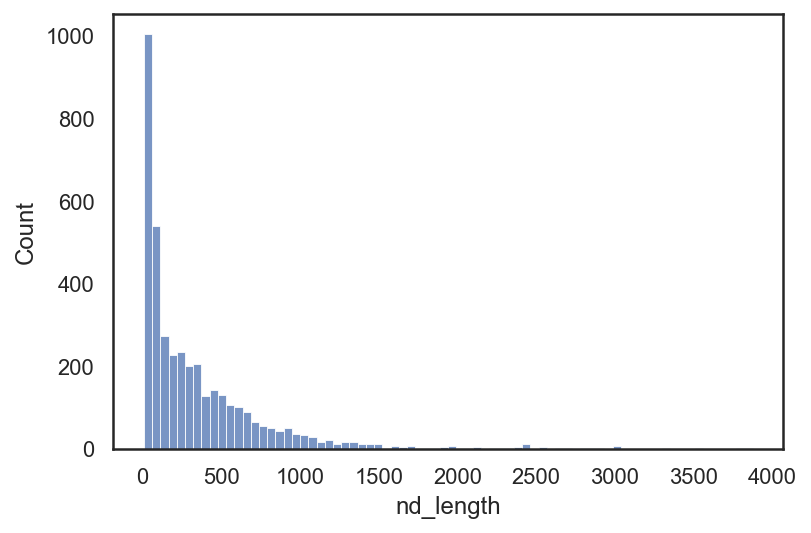

In [22]:
#most of the title+selftext tends to be short

sns.histplot(nut_die,x='nd_length');

>**create a new column for the word count**

In [23]:
nut_die['nd_word_count']=nut_die['title_text'].str.count(' ')+1

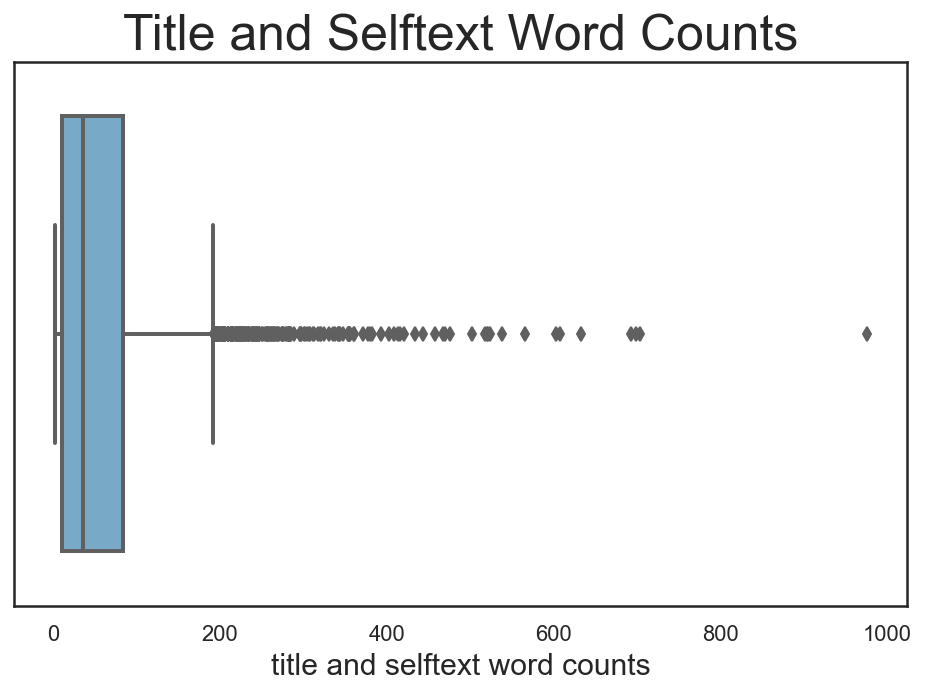

In [24]:
# draw a boxplot to find out outliers again

plt.figure(figsize=(8,5))

sns.set_theme(style='white')
sns.boxplot(x=nut_die['nd_word_count'],palette='Blues', linewidth=2)

plt.title('Title and Selftext Word Counts', size=25)
plt.xlabel('title and selftext word counts',size=15);

In [25]:
#find out the outliers

nut_die.sort_values(by=['nd_word_count']).tail()

,subreddit,title_text,nd_length,nd_word_count
3453,0,Advice on my future Hello fellow dieticians \n...,3521,633
2757,0,Passed RD Exam! + Tips! Hey everyone!\n\nSuper...,3842,693
2337,0,"Toxic, unprofessional boss/ Advice for applyin...",3818,698
2037,0,Diet And Exercising For Weight Loss \n\nObes...,3873,703
1078,1,In need of any tips/advice on my vitamin regim...,2541,975


In [26]:
#drop the one outlier

nut_die.drop([1078],axis=0,inplace=True)

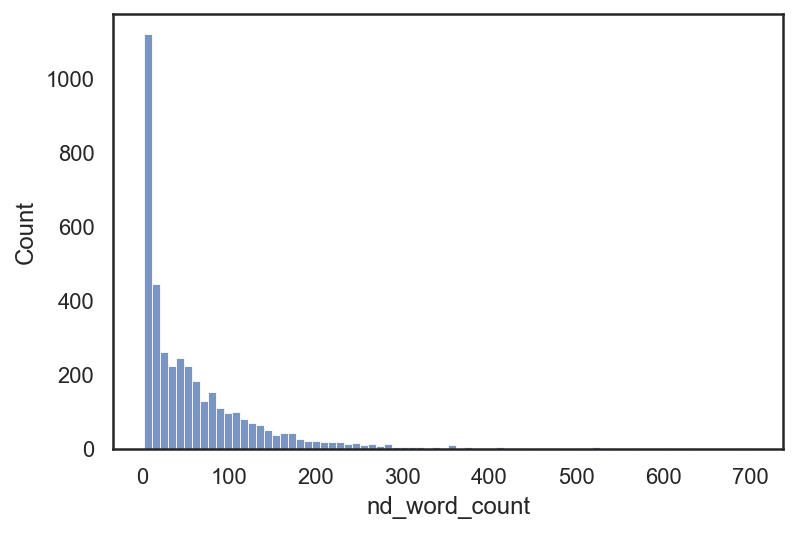

In [27]:
#just want to see if there is anything wired

sns.histplot(nut_die,x='nd_word_count');

In [28]:
# rename the columns name, so there is not dupilicated column name later, with the column
#created by the CountVectorizer/TfidfVectorizer

nut_die=nut_die.rename(columns={'subreddit':'nd_subreddit','title_text':'nd_title_text'})

In [29]:
nut_die.head(2)

,nd_subreddit,nd_title_text,nd_length,nd_word_count
0,1,Please help me figure out what’s wrong with my...,84,12
1,1,What Tests For Iron Deficiency? Looking at get...,335,54


> **create a new column using sentiment analyzer**

https://git.generalassemb.ly/lettywu/6.03-advanced-pipelines

In [30]:
# instantiate the sentiment analyzer

sia = SentimentIntensityAnalyzer()

In [31]:
# Write a function to get the compound sentiment scores for a post

def get_compound_sentiment(post):
    return sia.polarity_scores(post)['compound']   

In [32]:
#apply the function above to the nd_title_text column

nut_die['nd_sentiment']=nut_die['nd_title_text'].apply(get_compound_sentiment)

In [33]:
nut_die.head()

,nd_subreddit,nd_title_text,nd_length,nd_word_count,nd_sentiment
0,1,Please help me figure out what’s wrong with my...,84,12,0.2942
1,1,What Tests For Iron Deficiency? Looking at get...,335,54,0.6544
2,1,How to get protein as a picky eater? [removed],46,9,0.0000
3,1,Suffering with canker sores [removed],37,5,-0.4767
4,1,Good diets/work outs? I am trying to lose weig...,204,39,0.2960


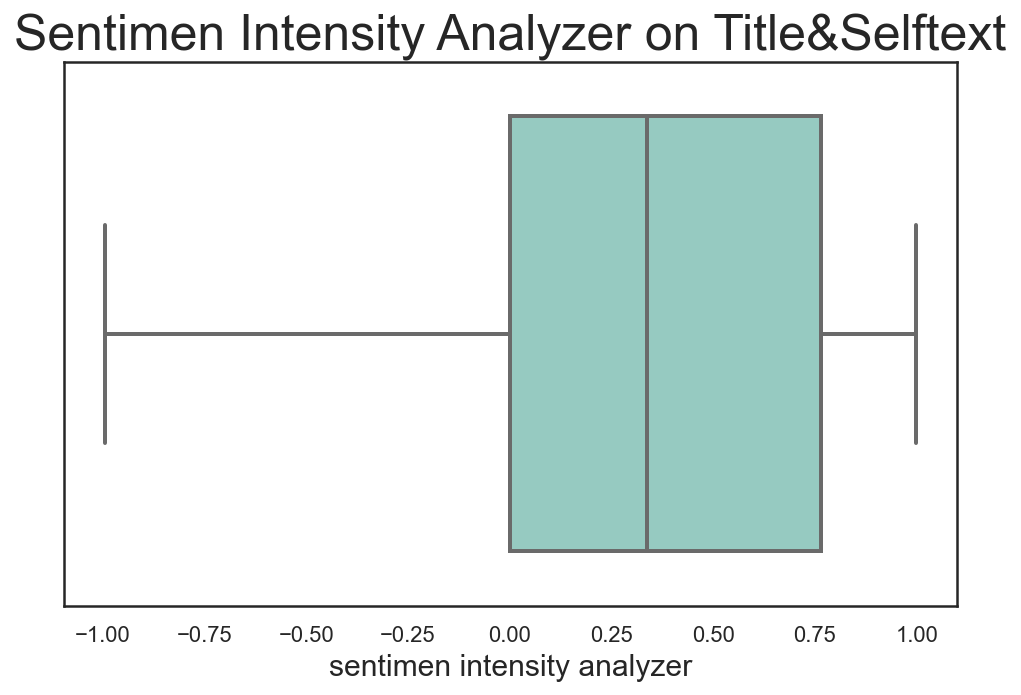

In [34]:
plt.figure(figsize=(8,5))

sns.set_theme(style='white')
sns.boxplot(x=nut_die['nd_sentiment'],palette='Set3', linewidth=2)

plt.title('Sentimen Intensity Analyzer on Title&Selftext', size=25)
plt.xlabel('sentimen intensity analyzer',size=15);

# I guess this won't tell us much, cause sentimen intensity analyzer
# returns a score between -1 and 1

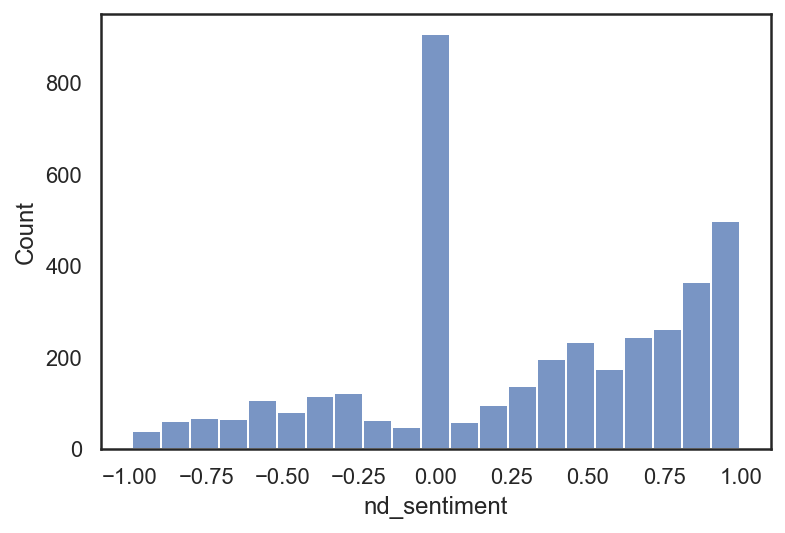

In [35]:
sns.histplot(nut_die,x='nd_sentiment');

#most of the texts are neutual 

In [36]:
#nut_die.to_csv('/Users/lettywu/dsi/Projects/project_3/project_3_letty/data/nutrition_vs_dietetics.csv',index=False)

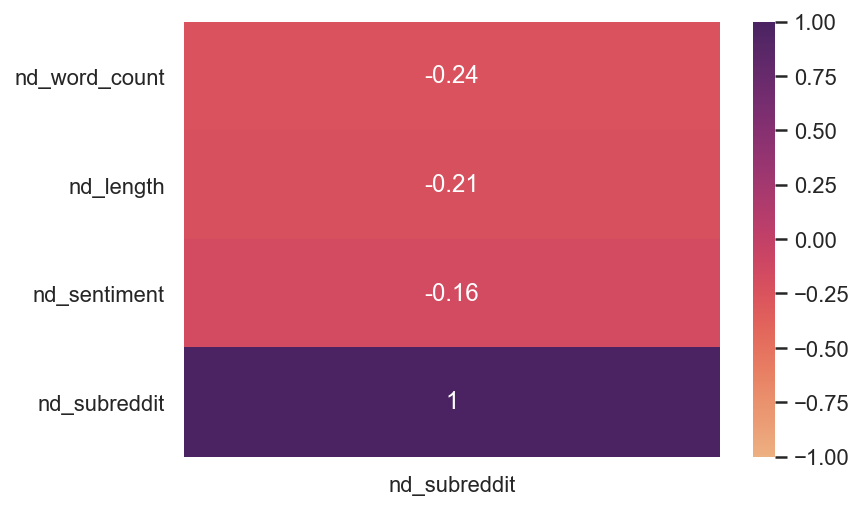

In [37]:
# seems like in general posts in nutrition subreddit are shorter
# and posts in nutrition are slightly negative than posts in dietetics subreddit

corr=nut_die.corr()[['nd_subreddit']].sort_values(by='nd_subreddit')
sns.heatmap(corr,annot=True,cmap='flare',vmin=-1,vmax=1);

In [38]:
corr=nut_die.corr()[['nd_subreddit']].sort_values(by='nd_subreddit')
corr

,nd_subreddit
nd_word_count,-0.235711
nd_length,-0.214227
nd_sentiment,-0.163745
nd_subreddit,1.000000


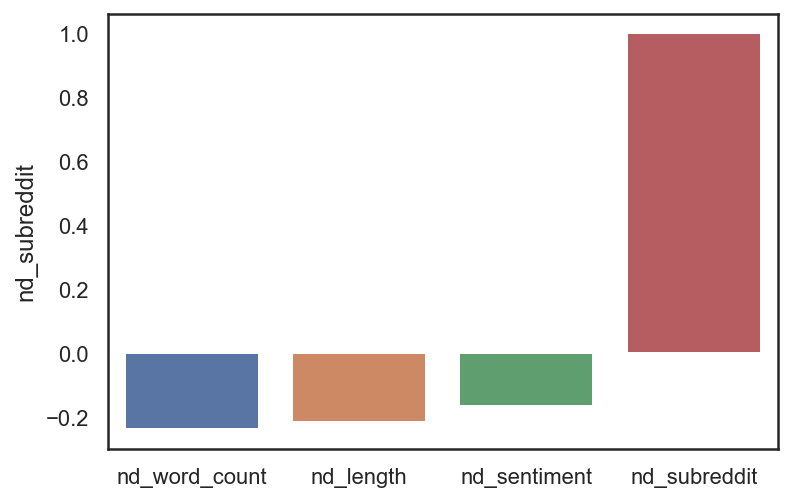

In [39]:
# just want to plot the corr in a barplot and see if anything interesting

sns.barplot(data=corr, y=corr.nd_subreddit,x=corr.index);

---

## CountVectorizer with WordNetLemmatizer()

In [40]:
# add custized stopwords into the 'english' stopwords

stopwords = nltk.corpus.stopwords.words('english')
newstopwords=['get','im','removed','ive','dont','rd','would','nutrition','deleted',"'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo']
stopwords.extend(newstopwords)

**adding LemmaTokenizer into CountVectorizer**

In [41]:
#https://scikit-learn.org/stable/modules/feature_extraction.html
#https://stackoverflow.com/questions/50155188/lemmatization-on-countvectorizer-doesnt-remove-stopwords
#https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer

class LemmaTokenizer:
    def __init__(self):
        self.wnl=WordNetLemmatizer()
    def __call__(self,doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in stopwords]

In [42]:
# instantiate CountVectorizer

cvec=CountVectorizer(tokenizer=LemmaTokenizer(),stop_words=stopwords,
                     max_features=5000,min_df=2,max_df=0.98,ngram_range=(1,2))

In [43]:
# fit&transform the nd_title_text column after replace all the puncation and numbers

title_text_countv=cvec.fit_transform(nut_die['nd_title_text']\
                                     .str.replace('[^\w\s]', '').str.replace('\d+', ''))

<ipython-input-43-c7c4bb66f07d>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  title_text_countv=cvec.fit_transform(nut_die['nd_title_text']\


In [44]:
title_text_countv.shape

(3929, 5000)

In [45]:
# create a new dataframe out of the CountVectorizer

title_text_countv_df=pd.DataFrame(title_text_countv.todense(),columns=cvec.get_feature_names())

In [46]:
title_text_countv_df.head(2)

,ab,abbott,abdomen,ability,able,able find,able help,abroad,absolute,absolutely,...,youre,youth,youtube,youve,yr,yummy,zero,zinc,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Common words overall

In [47]:
title_text_countv_df.sum().sort_values()[-20:]

feel         424
advice       430
weight       456
much         466
question     489
also         500
help         515
dietitian    519
one          529
year         532
want         533
work         548
day          552
time         553
diet         574
anyone       675
know         771
job          777
food         793
like         851
dtype: int64

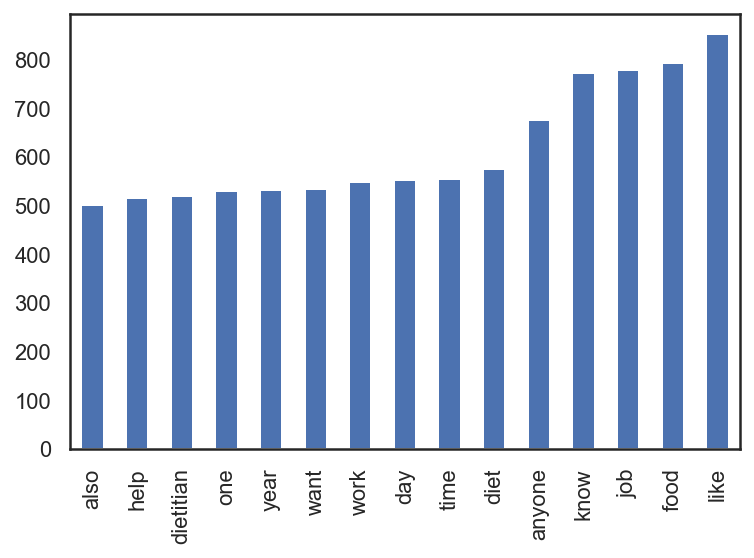

In [48]:
title_text_countv_df.sum().sort_values()[-15:].plot(kind='bar');

**make a new df for the common words overall to plot later**

In [49]:
countv_df=pd.DataFrame(title_text_countv_df.sum().sort_values()[-15:],columns=['counts'])
countv_df.sort_values(by=['counts'],ascending=False).head(1)

,counts
like,851


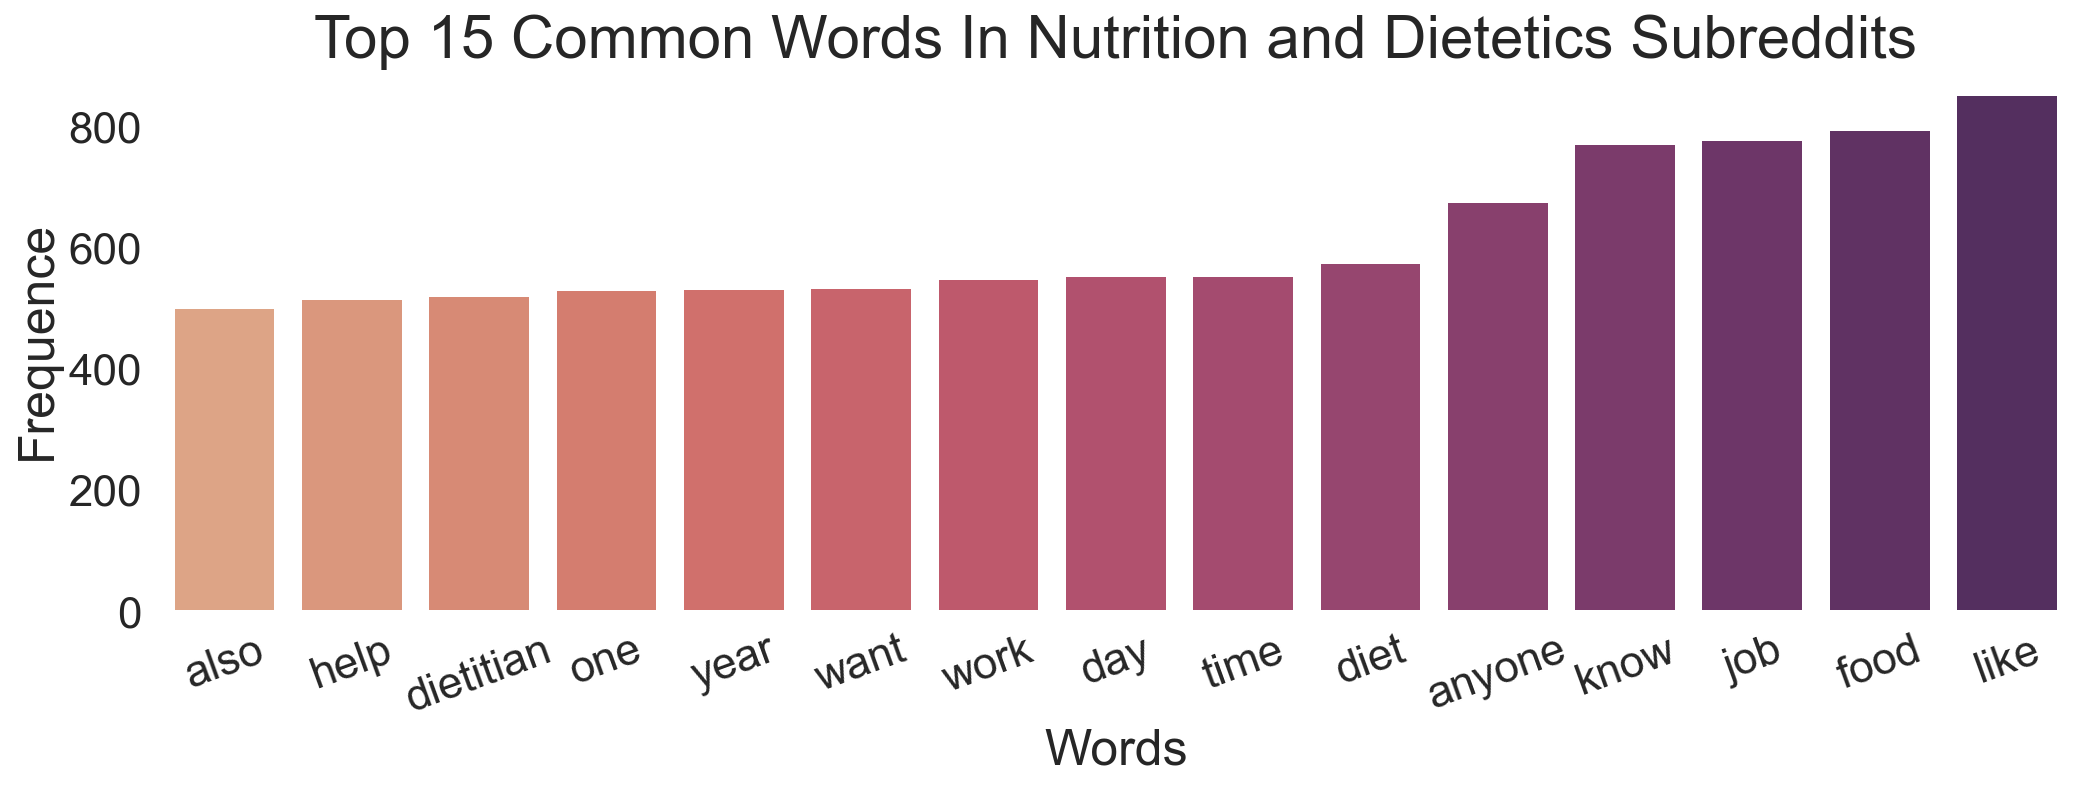

In [50]:
plt.figure(figsize=(15,6))

sns.set(font_scale=2) #change the font size for charts in entire notebook
sns.set_style('white')

p=sns.barplot(data=countv_df.sort_values(by=['counts'],ascending=False),
            y=countv_df.counts,x=countv_df.index, palette='flare')
 
plt.xlabel("Words",size=25)
plt.ylabel("Frequence",size=25)
plt.title('Top 15 Common Words In Nutrition and Dietetics Subreddits',size=30)

plt.xticks(rotation=20)

#plt.gca().invert_yaxis()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tight_layout()
plt.savefig('../images/common_words_overall',transparent=True);

# this barplot shows the top 15 common words in both nutrition and dietetics subreddits
# however, regarding to my problem statement, it's not really informative

**combine the nutrition/dietitian dataframe and the CountVectorizer dataframe**

In [51]:
nut_die_countv_df=pd.concat([nut_die,title_text_countv_df],axis=1)

In [52]:
nut_die_countv_df.head(2)

,nd_subreddit,nd_title_text,nd_length,nd_word_count,nd_sentiment,ab,abbott,abdomen,ability,able,...,youre,youth,youtube,youve,yr,yummy,zero,zinc,zone,zoom
0,1.0,Please help me figure out what’s wrong with my...,84.0,12.0,0.2942,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,What Tests For Iron Deficiency? Looking at get...,335.0,54.0,0.6544,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### some common words for subreddit nutrition 

In [53]:
nut_die_countv_df.loc[nut_die_countv_df['nd_subreddit']==1].drop(columns='nd_title_text').sum().sort_values()[-20:-3]

good            202.0000
healthy         210.0000
one             219.0000
much            233.0000
weight          234.0000
fat             236.0000
vitamin         255.0000
know            266.0000
eating          266.0000
like            281.0000
day             290.0000
protein         297.0000
eat             299.0000
diet            306.0000
calorie         323.0000
nd_sentiment    390.3207
food            508.0000
dtype: float64

In [54]:
# droped the nd_sentiment row, so it doesn't show up in my chart later

nut_die_countv_df.loc[nut_die_countv_df['nd_subreddit']==1].drop(columns='nd_title_text').sum().sort_values().drop(labels=['nd_sentiment'])[-20:-3]

sugar      199.0
good       202.0
healthy    210.0
one        219.0
much       233.0
weight     234.0
fat        236.0
vitamin    255.0
know       266.0
eating     266.0
like       281.0
day        290.0
protein    297.0
eat        299.0
diet       306.0
calorie    323.0
food       508.0
dtype: float64

In [55]:
#create a df for the common words in nutrition subreddit

words_nut=pd.DataFrame(nut_die_countv_df.loc[nut_die_countv_df['nd_subreddit']==1].
                       drop(columns='nd_title_text').sum().sort_values().drop(labels=['nd_sentiment'])[-18:-3],
                       columns=['nut_counts'])

words_nut=words_nut.astype({'nut_counts':int})

words_nut#.sort_values(by=['nut_counts'],ascending=False).head(2)

,nut_counts
healthy,210
one,219
much,233
weight,234
fat,236
vitamin,255
know,266
eating,266
like,281
day,290


In [56]:
len(words_nut)

15

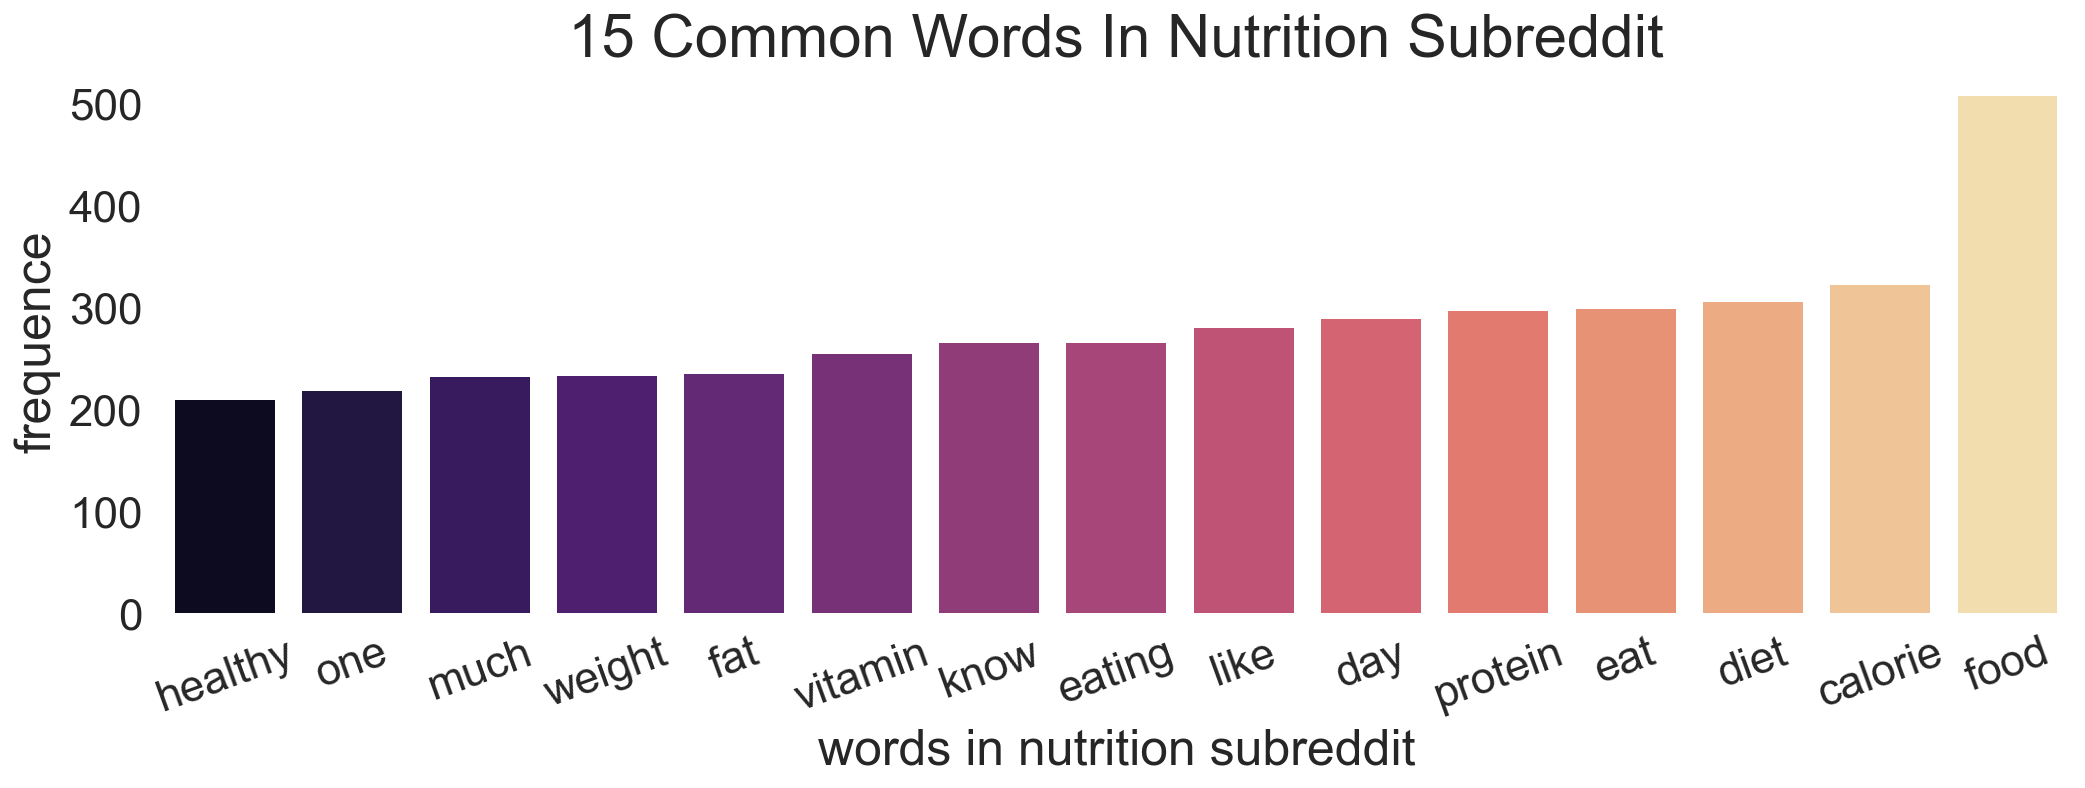

In [57]:
plt.figure(figsize=(15,6))

sns.set(font_scale=2)
sns.set_style('white')

sns.barplot(data=words_nut,y=words_nut['nut_counts'],x=words_nut.index, palette='magma')
 
plt.xlabel("words in nutrition subreddit",size=25)
plt.ylabel("frequence",size=25)
plt.title('15 Common Words In Nutrition Subreddit',size=30);

plt.xticks(rotation=20)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tight_layout()
plt.savefig('../images/common_words_in_nutrition',transparent=True);

# create a barplot here for the 15 most common words in nutrition subreddit

### some common words for subreddit dietetics

In [58]:
nut_die_countv_df.loc[nut_die_countv_df['nd_subreddit']==0].drop(columns='nd_title_text').sum().sort_values()[-18:-4]

patient       340.0
exam          344.0
program       349.0
advice        354.0
experience    362.0
internship    368.0
want          403.0
time          410.0
year          461.0
work          468.0
know          504.0
dietitian     511.0
anyone        533.0
like          567.0
dtype: float64

In [59]:
# create a df here to plot later

words_die=pd.DataFrame(nut_die_countv_df.loc[nut_die_countv_df['nd_subreddit']==0].
                       drop(columns='nd_title_text').sum().sort_values()[-18:-4],
                       columns=['die_counts'])
words_die=words_die.astype({'die_counts':int})
words_die.sort_values(by=['die_counts'],ascending=False).head(2)

,die_counts
like,567
anyone,533


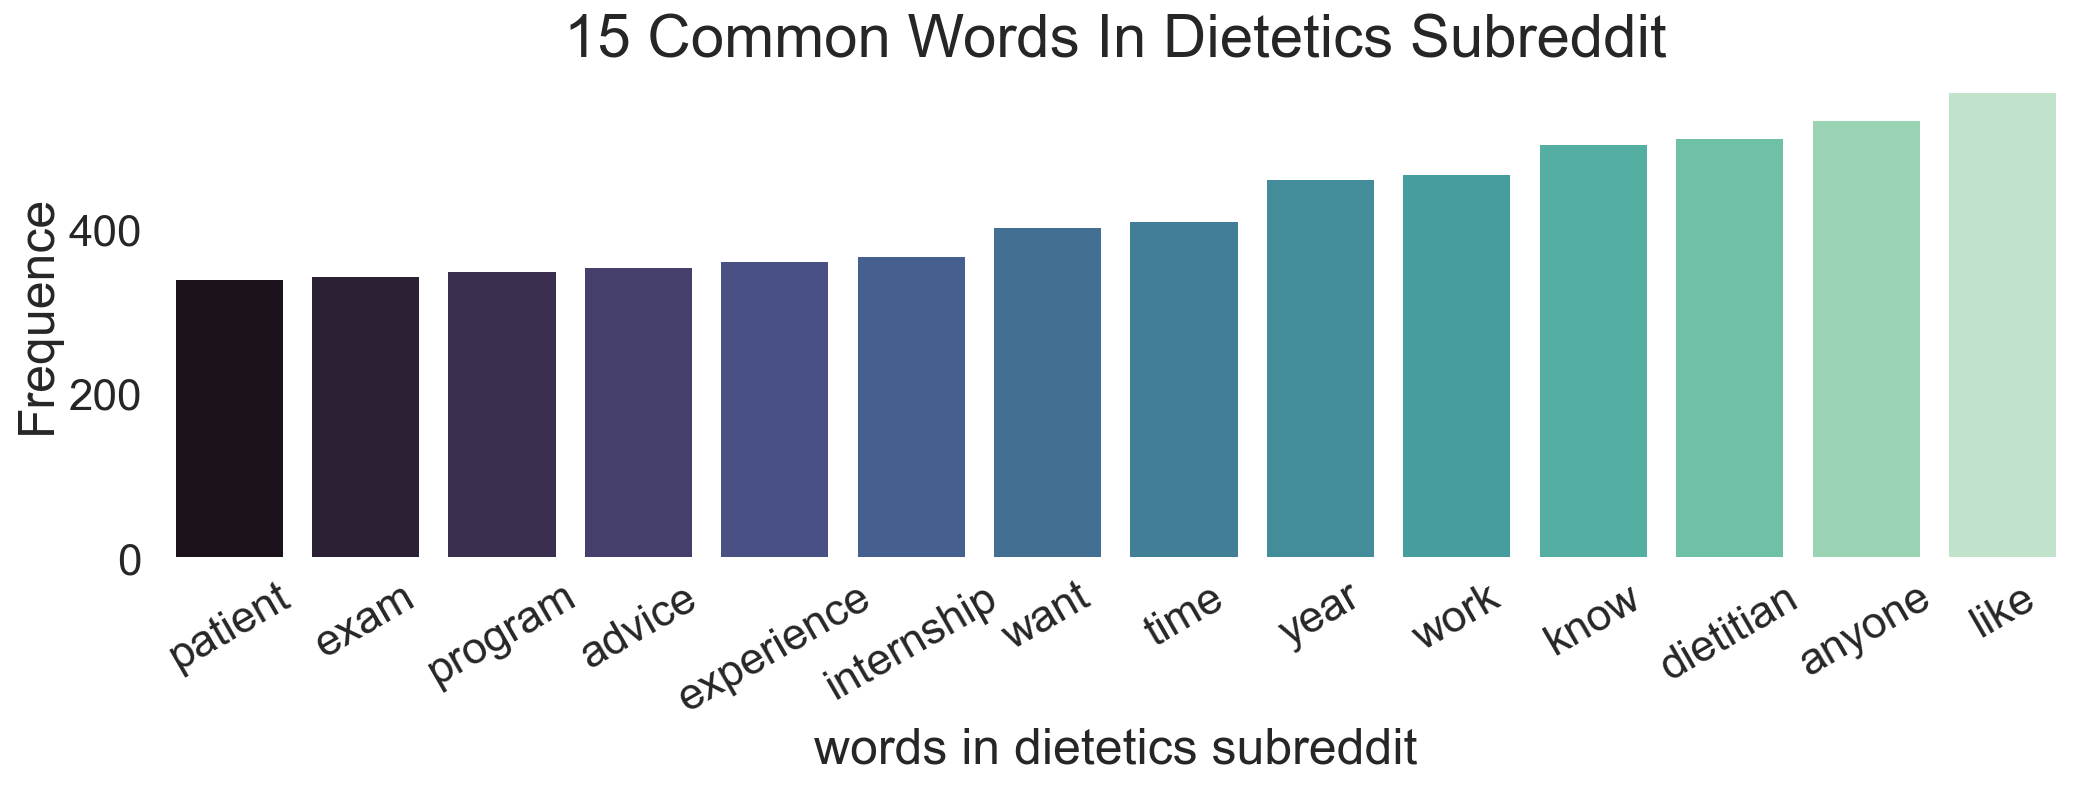

In [60]:
plt.figure(figsize=(15,6))

sns.set(font_scale=2)
sns.set_style('white')

sns.barplot(data=words_die,y=words_die['die_counts'],
            x=words_die.index, palette='mako')
 
plt.xlabel("words in dietetics subreddit",size=25)
plt.ylabel("Frequence",size=25)
plt.title('15 Common Words In Dietetics Subreddit',size=30)

plt.xticks(rotation=30)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tight_layout()
plt.savefig('../images/common_words_in_dietetics',transparent=True);

# create a barplot to show the 15 most common words in dietetics subreddit

---

## CountVectorizer without WordNetLemmatizer()

In [61]:
# add customized stopwords in to 'english' stopwords

stopwords = nltk.corpus.stopwords.words('english')
newstopwords=['get','im','removed','ive','dont','rd','would','nutrition','deleted',"'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo']
stopwords.extend(newstopwords)

In [62]:
# instantiate CountVectorizer 

cvec=CountVectorizer(stop_words=stopwords,
                     max_features=5000,min_df=2,max_df=0.98,ngram_range=(1,2))

In [63]:
title_text_countv=cvec.fit_transform(nut_die['nd_title_text'].str.replace('\d+', ''))

<ipython-input-63-c0ccd35efcf4>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  title_text_countv=cvec.fit_transform(nut_die['nd_title_text'].str.replace('\d+', ''))


In [64]:
title_text_countv.shape

(3929, 5000)

In [65]:
# create a new dataframe out of the CountVectorizer

title_text_countv_df=pd.DataFrame(title_text_countv.todense(),columns=cvec.get_feature_names())

In [66]:
title_text_countv_df.head(2)

,abbott,abdomen,ability,able,able find,able help,abroad,abs,absolute,absolutely,...,younger,youth,youtu,youtube,youtube com,yr,yummy,zero,zinc,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
# some common words on both subreddits

title_text_countv_df.sum().sort_values()[-20:]

feel         394
https        396
dietitian    397
good         406
advice       447
weight       453
day          455
much         467
one          480
help         495
also         500
want         507
time         513
work         516
diet         565
food         585
job          605
anyone       678
know         750
like         850
dtype: int64

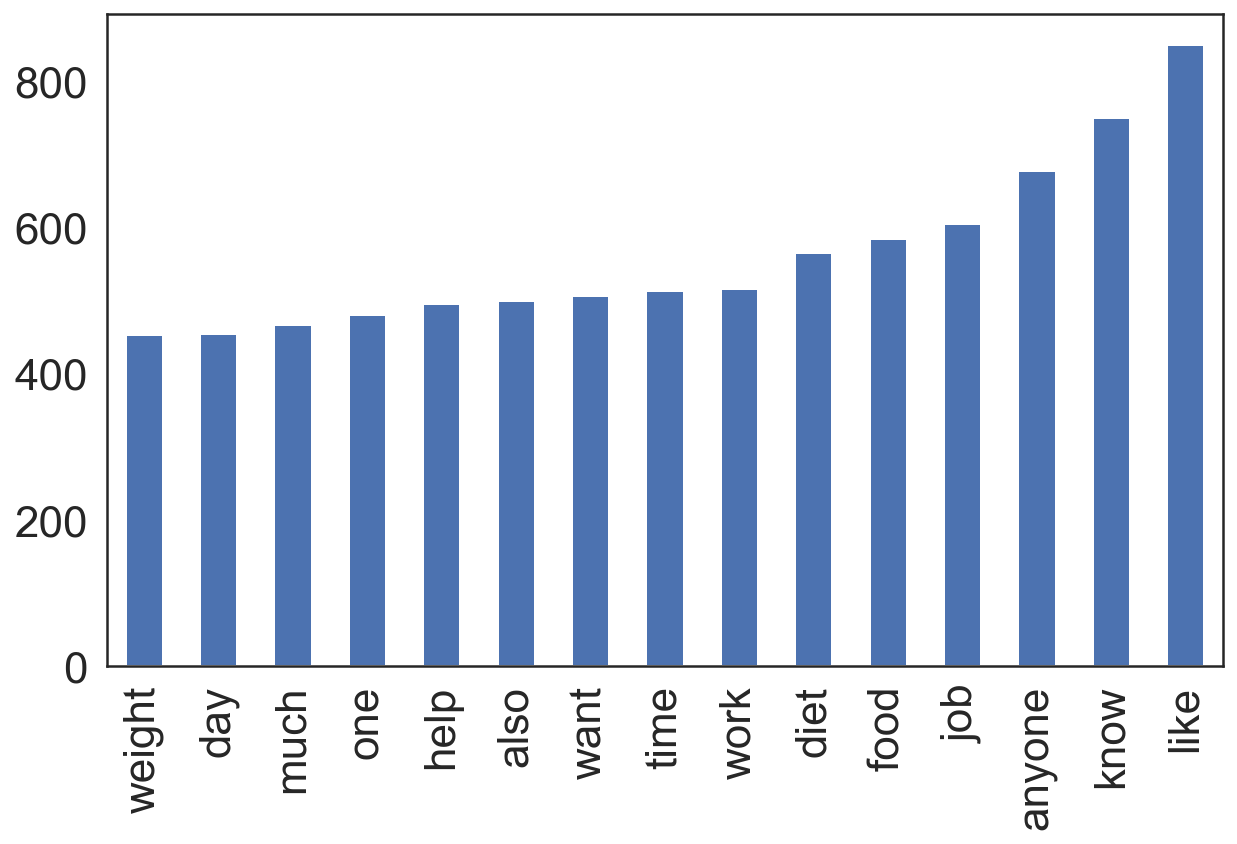

In [68]:
plt.figure(figsize=(10,6))
title_text_countv_df.sum().sort_values()[-15:].plot(kind='bar');

**combine the nutrition/dietitian dataframe and the CountVectorizer dataframe**

In [69]:
nut_die_countv_df=pd.concat([nut_die,title_text_countv_df],axis=1)

In [70]:
nut_die_countv_df.head(2)

,nd_subreddit,nd_title_text,nd_length,nd_word_count,nd_sentiment,abbott,abdomen,ability,able,able find,...,younger,youth,youtu,youtube,youtube com,yr,yummy,zero,zinc,zoom
0,1.0,Please help me figure out what’s wrong with my...,84.0,12.0,0.2942,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,What Tests For Iron Deficiency? Looking at get...,335.0,54.0,0.6544,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
# some common words for subreddit nutrition 

nut_die_countv_df.loc[nut_die_countv_df['nd_subreddit']==1].drop(columns='nd_title_text').sum().sort_values()[-20:-4]

www         205.0
com         206.0
healthy     217.0
fat         219.0
much        234.0
weight      237.0
calories    239.0
day         240.0
https       254.0
know        257.0
eating      267.0
like        285.0
protein     290.0
diet        302.0
eat         302.0
food        346.0
dtype: float64

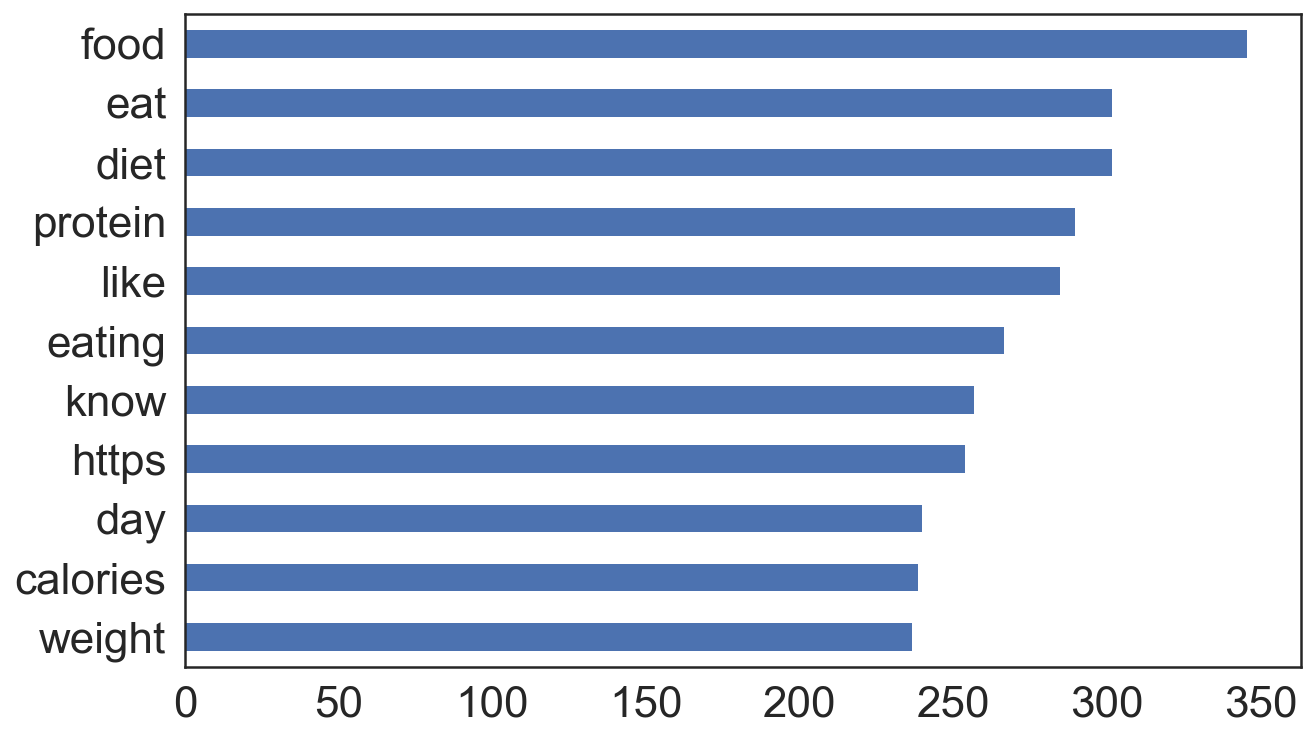

In [72]:
plt.figure(figsize=(10,6))
nut_die_countv_df.loc[nut_die_countv_df['nd_subreddit']==1].drop(columns='nd_title_text').sum().sort_values()[-15:-4].plot(kind='barh');

In [73]:
# some common words for subreddit dietetics

nut_die_countv_df.loc[nut_die_countv_df['nd_subreddit']==0].drop(columns='nd_title_text').sum().sort_values()[-15:-3]

internship    330.0
also          334.0
exam          334.0
advice        370.0
want          382.0
dietitian     390.0
time          401.0
work          452.0
know          492.0
anyone        536.0
like          563.0
job           587.0
dtype: float64

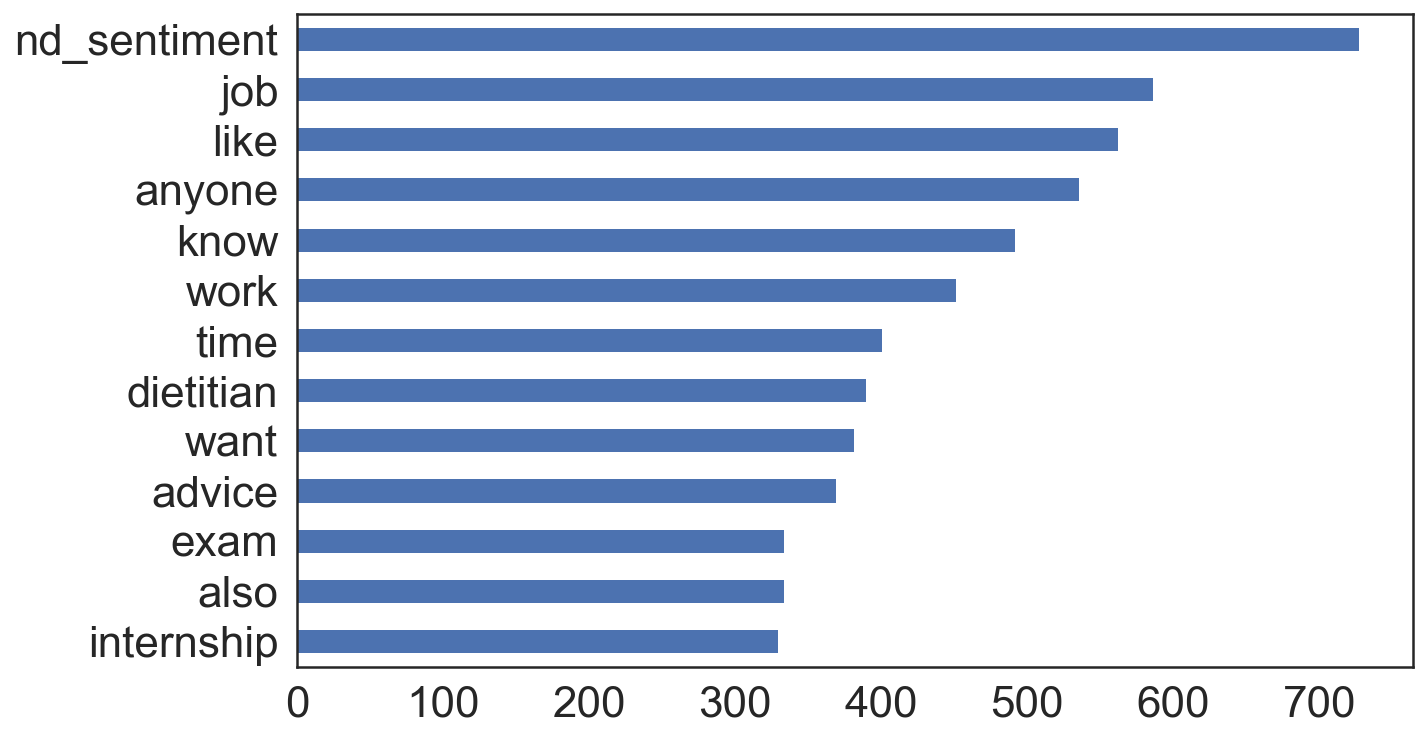

In [74]:
plt.figure(figsize=(10,6))
nut_die_countv_df.loc[nut_die_countv_df['nd_subreddit']==0].drop(columns='nd_title_text').sum().sort_values()[-15:-2].plot(kind='barh');

In [75]:
nut_die_countv_df.loc[nut_die_countv_df['nd_subreddit']==1,'www'].sum()

205.0

In [76]:
nut_die_countv_df.loc[nut_die_countv_df['nd_subreddit']==0,'www'].sum()

88.0

`I think it's better that I don't remove all the links, because appariently there are way more links in nutrition subreddit, but not as much in dietetics subreddit`

---

# TfidfVectorizer with WordNetLemmatizer()

In [77]:
# add customized stopwords into 'english' stopwords

stopwords = nltk.corpus.stopwords.words('english')
newstopwords=['get','im','removed','ive','dont','rd','would','nutrition','deleted',"'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo']
stopwords.extend(newstopwords)

`adding LemmaTokenizer into TfidfVectorizer`

In [78]:
#https://scikit-learn.org/stable/modules/feature_extraction.html
#https://stackoverflow.com/questions/50155188/lemmatization-on-countvectorizer-doesnt-remove-stopwords
#https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer

class LemmaTokenizer:
    def __init__(self):
        self.wnl=WordNetLemmatizer()
    def __call__(self,doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in stopwords]

In [79]:
# Instantiate the TfidfVectorizer

tvec=TfidfVectorizer(stop_words=stopwords,max_features=5000,min_df=2,max_df=0.98,
                     ngram_range=(1,2),tokenizer=LemmaTokenizer())

In [80]:
title_text_tfidf=tvec.fit_transform(nut_die['nd_title_text'].str.replace('[^\w\s]', '').str.replace('\d+', ''))

<ipython-input-80-02f241cb725b>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  title_text_tfidf=tvec.fit_transform(nut_die['nd_title_text'].str.replace('[^\w\s]', '').str.replace('\d+', ''))


In [81]:
title_text_tfidf.shape

(3929, 5000)

In [82]:
# create a new dataframe out of the TfidfVectorizer

title_text_tfidf_df=pd.DataFrame(title_text_tfidf.todense(),columns=tvec.get_feature_names())

In [83]:
title_text_tfidf_df.head(2)

,ab,abbott,abdomen,ability,able,able find,able help,abroad,absolute,absolutely,...,youre,youth,youtube,youve,yr,yummy,zero,zinc,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Value words on both subreddits

In [84]:
title_text_tfidf_df.sum().sort_values()[-15:]

eat          43.852753
question     45.488075
advice       45.692582
eating       45.836580
protein      46.407383
day          47.003137
dietitian    51.935812
like         54.782306
know         55.746448
help         56.245818
anyone       58.040391
weight       62.226975
job          64.973243
diet         66.988743
food         74.921099
dtype: float64

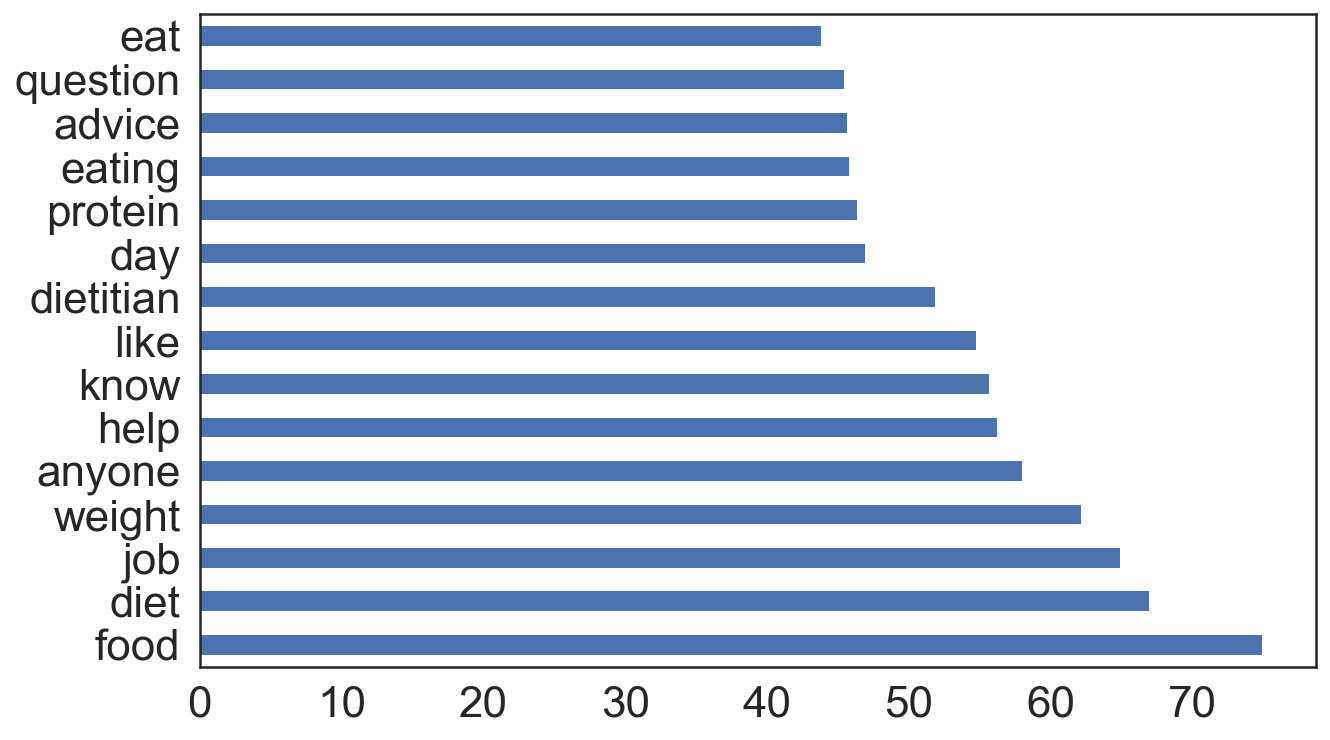

In [85]:
plt.figure(figsize=(10,6))
title_text_tfidf_df.sum().sort_values(ascending=False).head(15).plot(kind='barh');

In [86]:
# create a df for the common words to plot later

tfidf_df=pd.DataFrame(title_text_tfidf_df.sum().sort_values()[-15:],columns=['scores'])
tfidf_df.sort_values(by=['scores'],ascending=False)

,scores
food,74.921099
diet,66.988743
job,64.973243
weight,62.226975
anyone,58.040391
help,56.245818
know,55.746448
like,54.782306
dietitian,51.935812
day,47.003137


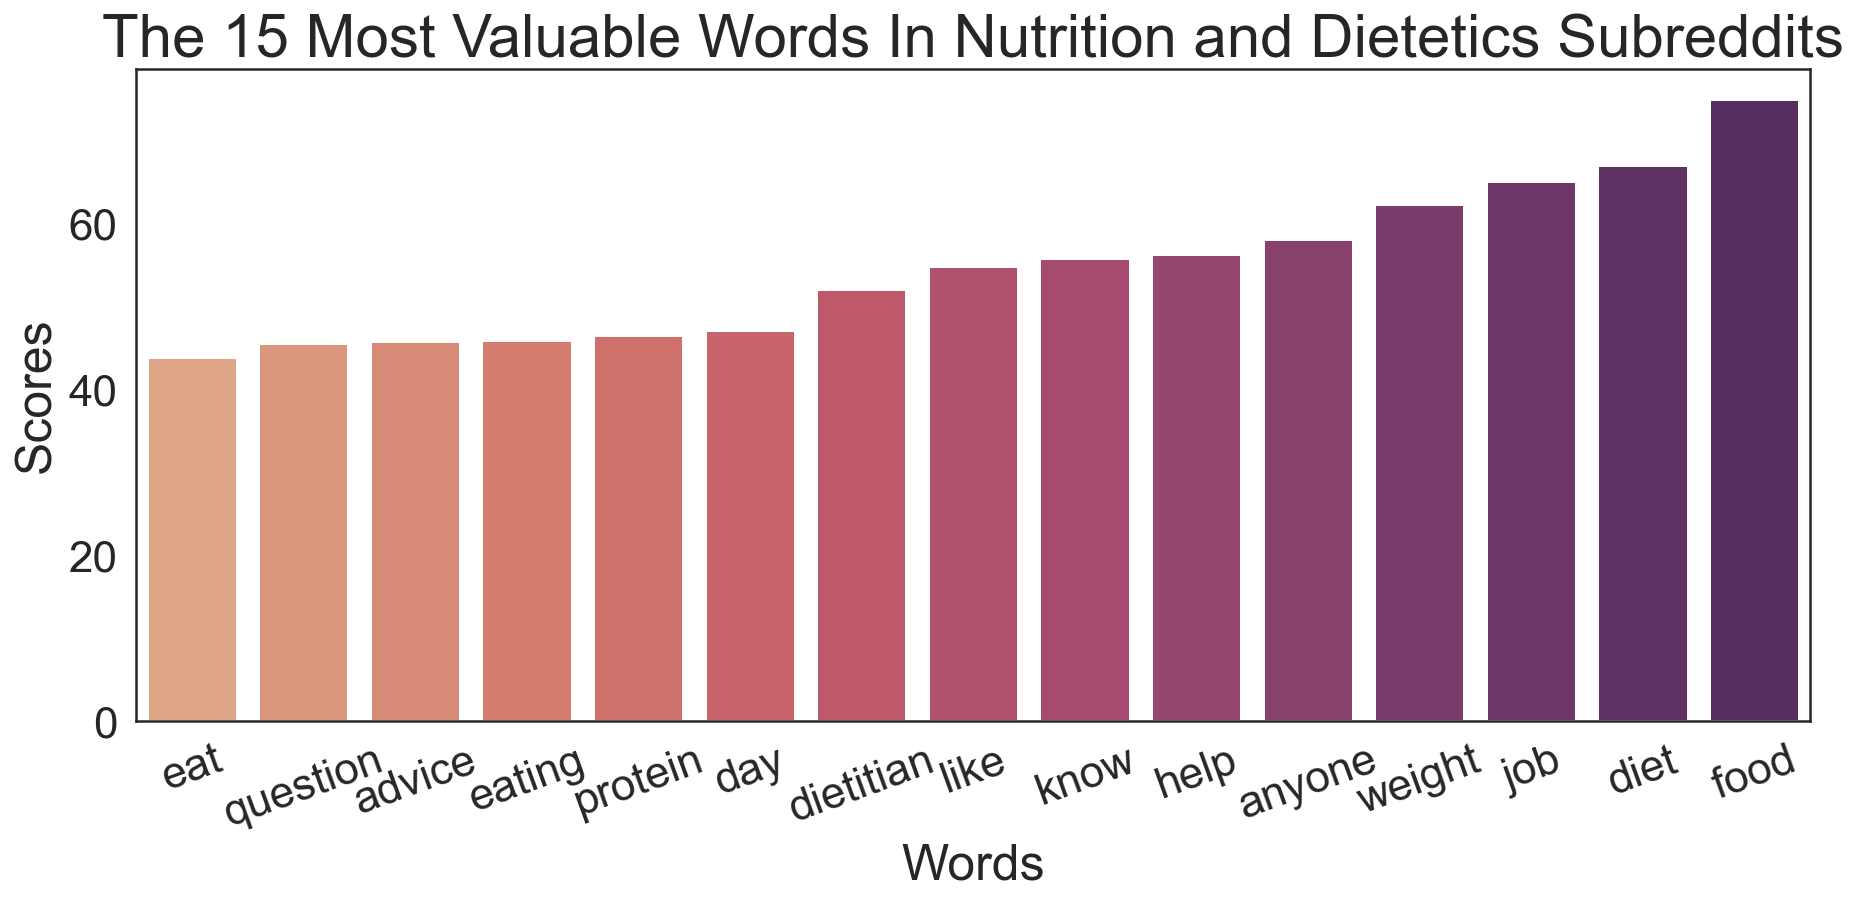

In [87]:
plt.figure(figsize=(15,6))

sns.set(font_scale=2) #change the font size for charts in entire notebook
sns.set_style('white')

sns.barplot(data=tfidf_df.sort_values(by=['scores'],ascending=False),
            y=tfidf_df.scores,x=tfidf_df.index, palette='flare')
 
plt.xlabel("Words",size=25)
plt.ylabel("Scores",size=25)
plt.title('The 15 Most Valuable Words In Nutrition and Dietetics Subreddits',size=30)

plt.xticks(rotation=20);

# did a barplot for the 15 most value words in both subreddits

**merge the origianl nutrituion/dietetic dataframe with tfidf dataframe**

In [88]:
nut_die_tifidf_df=pd.concat([nut_die,title_text_tfidf_df],axis=1)

In [89]:
nut_die_tifidf_df.shape

(3933, 5005)

### Value words for subreddit nutrition

In [90]:
nut_die_tifidf_df.loc[nut_die_tifidf_df['nd_subreddit']==1].drop(columns='nd_title_text').sum().sort_values()[-19:-4]

good       24.017526
much       24.379655
help       27.036320
sugar      27.364299
fat        27.876173
day        29.420758
healthy    31.264380
eating     35.046736
vitamin    35.111512
eat        37.329960
calorie    38.006924
protein    38.896171
diet       40.546895
weight     43.840851
food       53.563260
dtype: float64

In [91]:
# create a df for the important words to plot later

words_nut_t=pd.DataFrame(nut_die_tifidf_df.loc[nut_die_tifidf_df['nd_subreddit']==1].
                       drop(columns='nd_title_text').sum().sort_values()[-19:-4],
                       columns=['nut_counts_t'])

words_nut_t.sort_values(by=['nut_counts_t'],ascending=False).head(2)

,nut_counts_t
food,53.563260
weight,43.840851


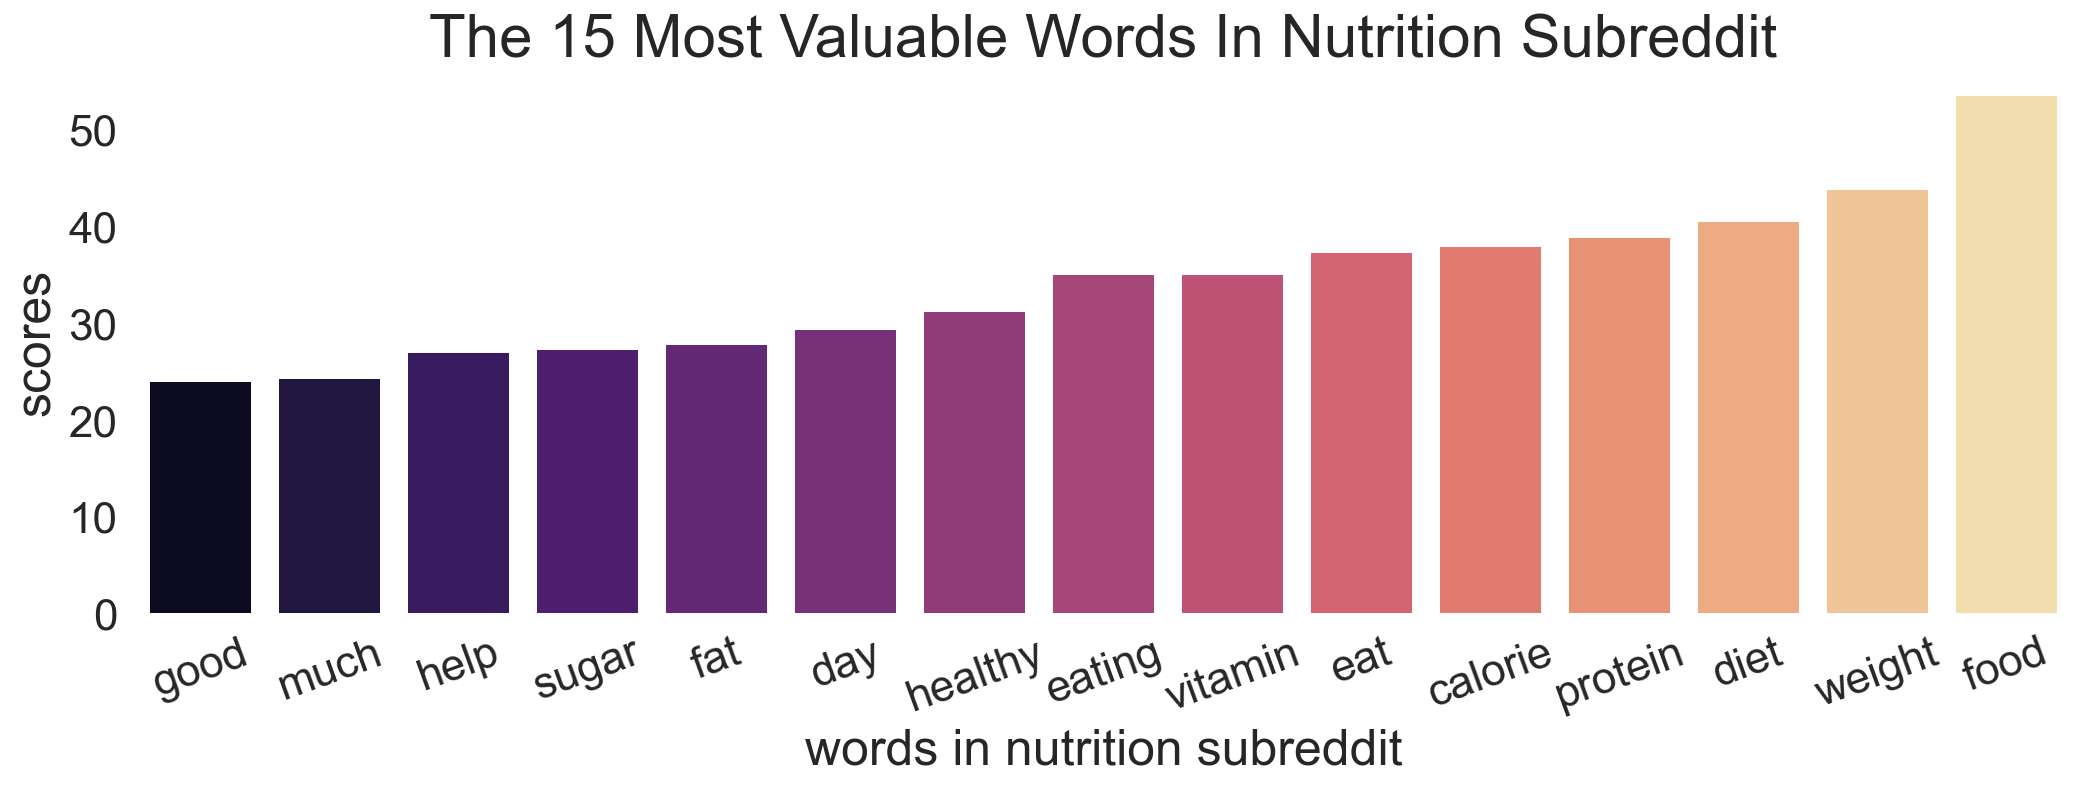

In [92]:
plt.figure(figsize=(15,6))

sns.set(font_scale=2)
sns.set_style('white')

sns.barplot(data=words_nut_t,y=words_nut_t['nut_counts_t'],x=words_nut_t.index, palette='magma')
 
plt.xlabel("words in nutrition subreddit",size=25)
plt.ylabel("scores",size=25)
plt.title('The 15 Most Valuable Words In Nutrition Subreddit',size=30)

plt.xticks(rotation=20)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tight_layout()
#plt.savefig('../images/valuable_words_in_nutrition',transparent=True);

# a barplot for the 15 most value words in Nutrition subreddit

### Value words for subreddit dietetics

In [93]:
nut_die_tifidf_df.loc[nut_die_tifidf_df['nd_subreddit']==0].drop(columns='nd_title_text').sum().sort_values()[-18:-3]

experience    30.337924
interview     30.357677
dietetics     31.036663
year          31.272595
clinical      31.521659
advice        32.454271
program       32.500464
know          33.341937
like          34.184416
internship    34.996417
work          35.623711
exam          42.021618
anyone        45.117064
dietitian     51.151918
job           63.039644
dtype: float64

In [94]:
# create a df for value words in dietetics subreddit to plot later

words_die_t=pd.DataFrame(nut_die_tifidf_df.loc[nut_die_tifidf_df['nd_subreddit']==0].
                       drop(columns='nd_title_text').sum().sort_values()[-18:-3],
                       columns=['die_counts_t'])

words_die_t.sort_values(by=['die_counts_t'],ascending=False).head(2)

,die_counts_t
job,63.039644
dietitian,51.151918


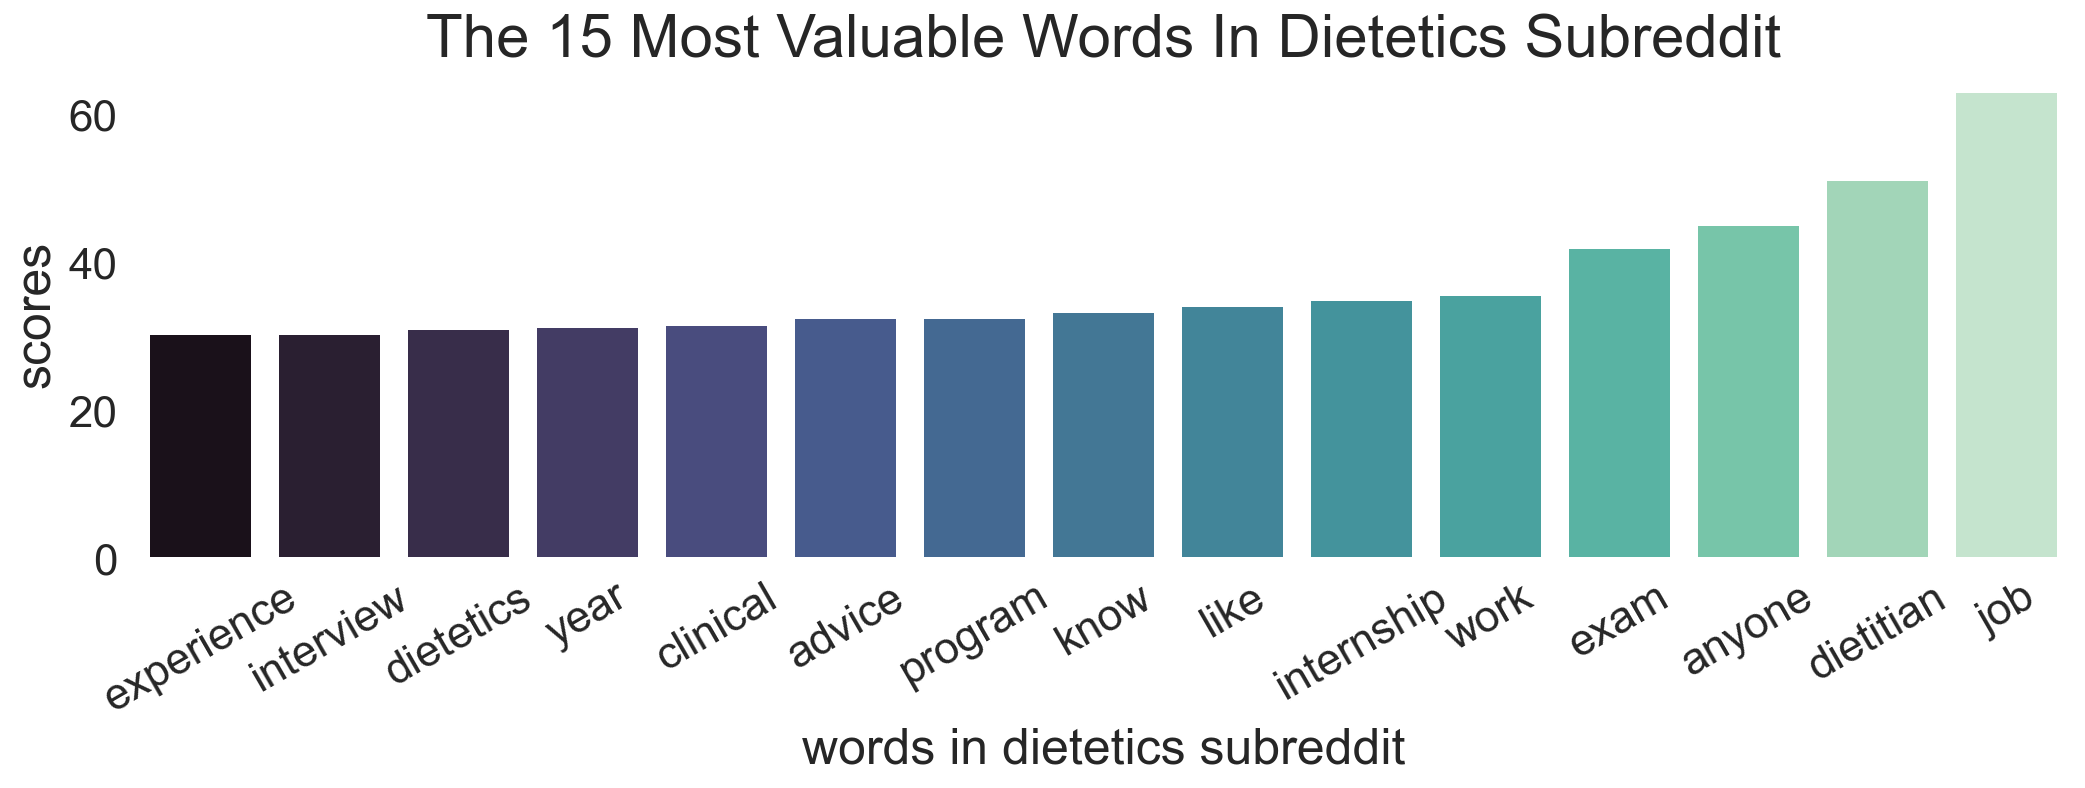

In [126]:
plt.figure(figsize=(15,6))

sns.set(font_scale=2)
sns.set_style('white')

sns.barplot(data=words_die_t,y=words_die_t['die_counts_t'],x=words_die_t.index, palette='mako')
 
plt.xlabel("words in dietetics subreddit",size=25)
plt.ylabel("scores",size=25)
plt.title('The 15 Most Valuable Words In Dietetics Subreddit',size=30)

plt.xticks(rotation=30)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tight_layout()
#plt.savefig('../images/valuable_words_in_dietetics',transparent=True);

# a barplot for the 15 most value words in dietetics subreddit

---

# TfidfVectorizer without WordNetLemmatizer()

In [96]:
# add customized stopwords into 'english' stopwords 

stopwords = nltk.corpus.stopwords.words('english')
newstopwords=['get','im','removed','ive','dont','rd','would','nutrition','deleted',"'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo']
stopwords.extend(newstopwords)

In [97]:
# Instantiate TfidfVectorizer

tvec=TfidfVectorizer(stop_words=stopwords,max_features=5000,min_df=2,max_df=0.98,
                     ngram_range=(1,2))

In [98]:
title_text_tfidf=tvec.fit_transform(nut_die['nd_title_text'])

In [99]:
title_text_tfidf.shape

(3929, 5000)

In [100]:
# create a new dataframe out of the TfidfVectorizer

title_text_tfidf_df=pd.DataFrame(title_text_tfidf.todense(),columns=tvec.get_feature_names())

In [101]:
title_text_tfidf_df.head(2)

,000,07,10,10 years,100,100 grams,1000,100g,11,12,...,young,younger,youth,youtu,youtube,youtube com,yummy,zero,zinc,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
# some most value words on both subreddits

title_text_tfidf_df.sum().sort_values()[-15:]

day        41.557746
work       42.215745
good       42.252054
eat        43.563409
eating     44.955057
protein    45.880343
advice     47.664936
job        54.043814
know       54.468800
like       54.503262
help       55.626883
food       57.880086
anyone     58.236382
weight     63.038089
diet       65.122604
dtype: float64

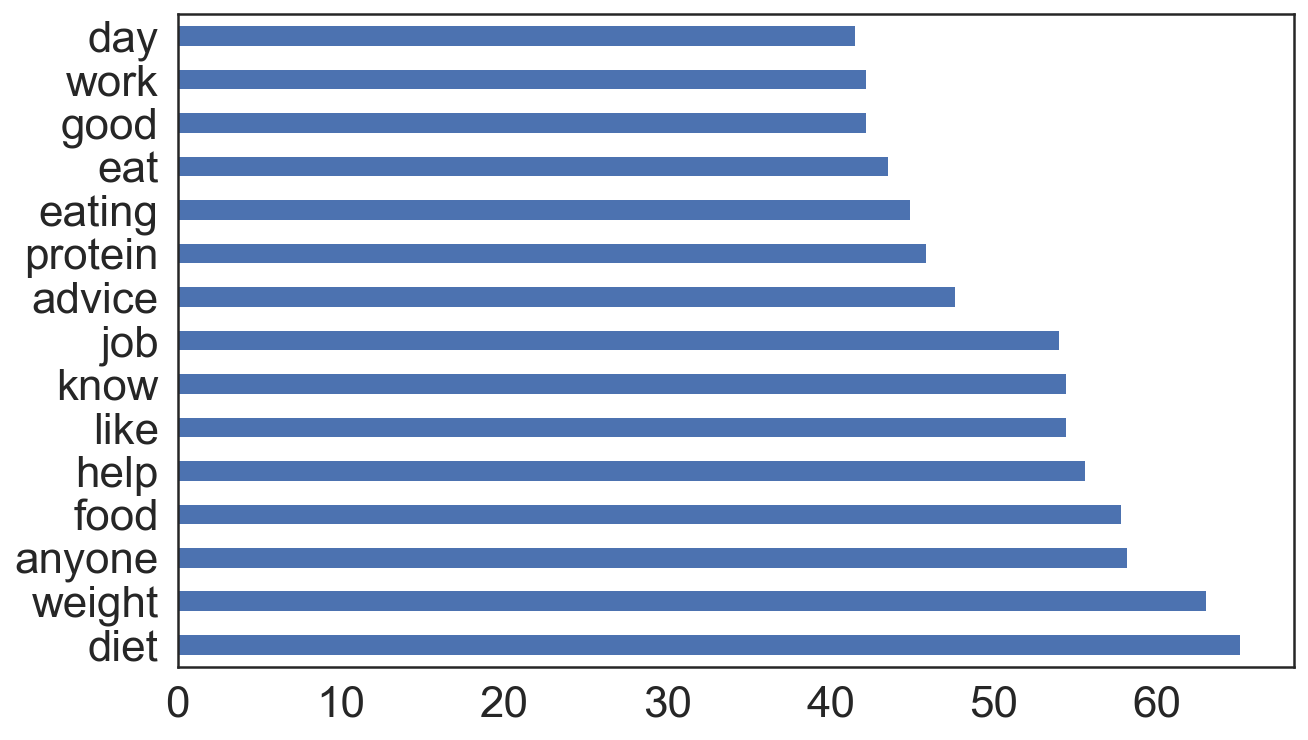

In [103]:
plt.figure(figsize=(10,6))
title_text_tfidf_df.sum().sort_values(ascending=False).head(15).plot(kind='barh');

**merge the origianl nutrituion/dietetic dataframe with tfidf dataframe**

In [104]:
nut_die_tifidf_df=pd.concat([nut_die,title_text_tfidf_df],axis=1)

In [105]:
nut_die_tifidf_df.shape

(3933, 5005)

In [106]:
# some most value words for subreddit nutrition 

nut_die_tifidf_df.loc[nut_die_tifidf_df['nd_subreddit']==1].drop(columns='nd_title_text').sum().sort_values()[-20:-4]

much        24.356403
good        24.551378
fat         24.566945
day         26.329424
help        26.334531
foods       26.548850
sugar       26.754980
vitamin     27.952498
calories    30.234392
healthy     32.453267
eating      34.342850
eat         36.988023
protein     38.350684
food        38.918777
diet        39.200191
weight      44.954977
dtype: float64

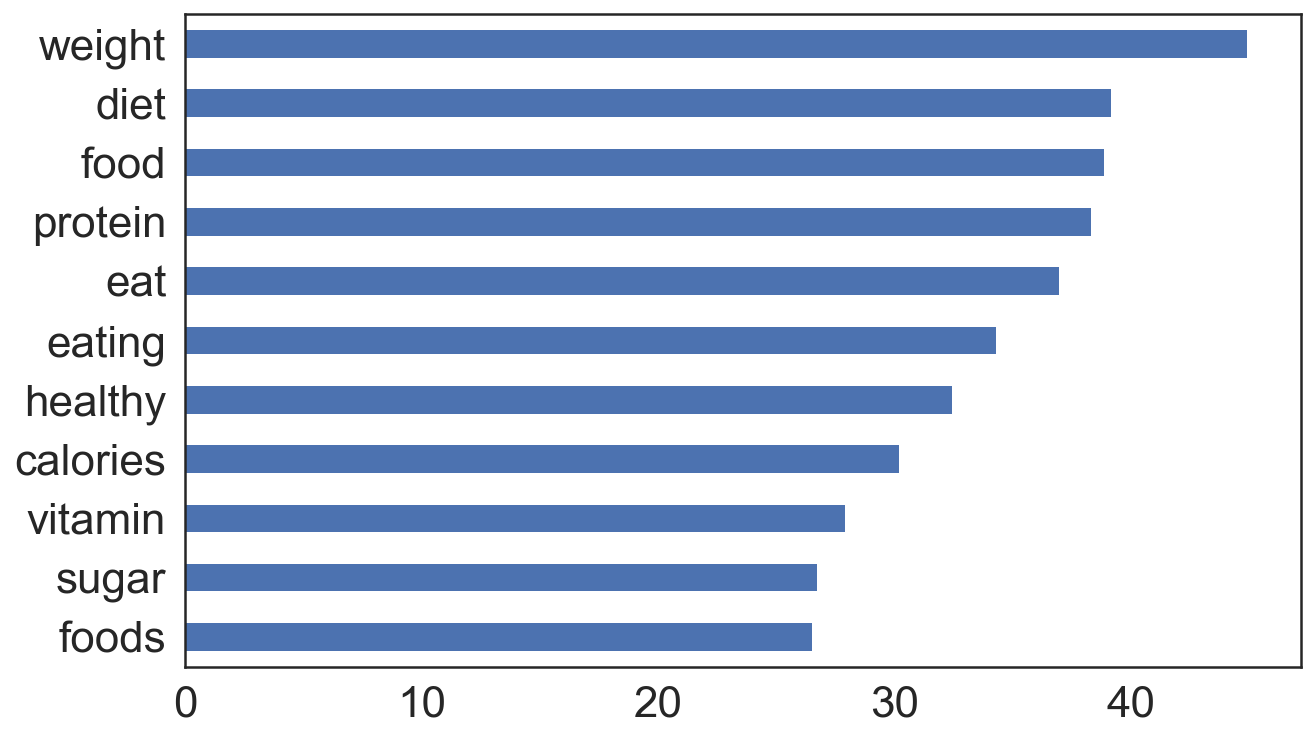

In [107]:
# plot the value words into a barchart for nutrition subreddit
plt.figure(figsize=(10,6))
nut_die_tifidf_df.loc[nut_die_tifidf_df['nd_subreddit']==1].drop(columns='nd_title_text').sum().sort_values()[-15:-4].plot(kind='barh');

In [108]:
# some most value words for subreddit dietetics

nut_die_tifidf_df.loc[nut_die_tifidf_df['nd_subreddit']==0].drop(columns='nd_title_text').sum().sort_values()[-20:-3]

experience    27.088918
want          27.488125
time          27.530926
interview     28.737799
help          29.292353
new           29.717222
internship    30.515322
clinical      32.160237
dietetics     32.516907
know          32.793854
advice        33.653273
like          33.955030
work          36.058975
dietitian     39.242944
exam          40.185860
anyone        45.212222
job           52.183492
dtype: float64

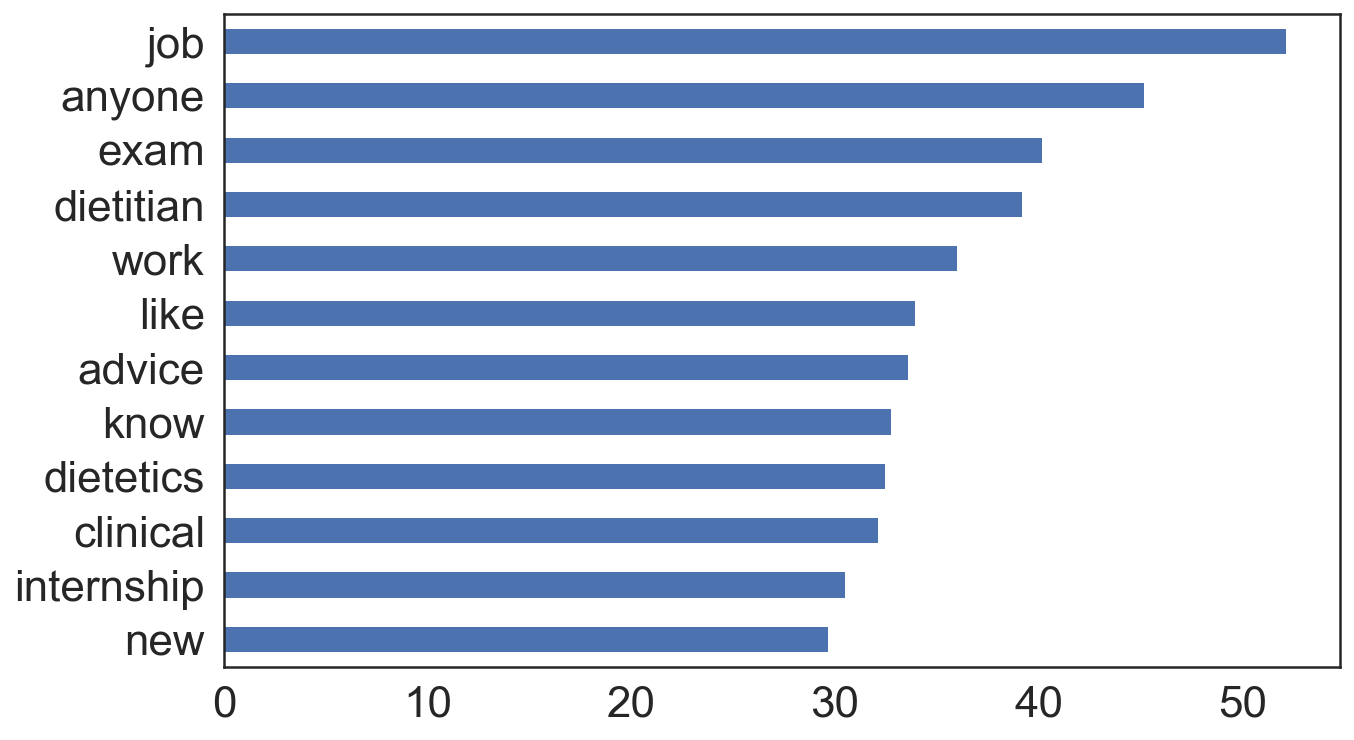

In [109]:
# plot the value words for dietetics subreddit into a barchart
plt.figure(figsize=(10,6))
nut_die_tifidf_df.loc[nut_die_tifidf_df['nd_subreddit']==0].drop(columns='nd_title_text').sum().sort_values()[-15:-3].plot(kind='barh');

---

# Part-of-speech tags

not very useful for modeling

In [110]:
# same stop words as above

stopwords = nltk.corpus.stopwords.words('english')
newstopwords=['get','im','removed','ive','dont','rd','would','nutrition','deleted',"'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo']
stopwords.extend(newstopwords)

In [111]:
# lowercase all the text

nut_die['nd_title_text'].str.lower()[:2]

0    please help me figure out what’s wrong with my...
1    what tests for iron deficiency? looking at get...
Name: nd_title_text, dtype: object

In [112]:
# instantiate a tokenizer to remove all the puntuation,and token by words

tokenizer=RegexpTokenizer(r'\w+')

In [113]:
# tokenize the text

title_text_reg=[tokenizer.tokenize(i) for i in nut_die['nd_title_text'].str.lower()]

In [114]:
# part-of-speech tagging using the Penn Treebank tags

title_text_tagged=[pos_tag(i) for i in title_text_reg if not i in stopwords]

In [115]:
title_text_tagged[0]

[('please', 'VB'),
 ('help', 'VB'),
 ('me', 'PRP'),
 ('figure', 'VB'),
 ('out', 'RP'),
 ('what', 'WP'),
 ('s', 'VBZ'),
 ('wrong', 'JJ'),
 ('with', 'IN'),
 ('my', 'PRP$'),
 ('macronutrient', 'NN'),
 ('calculations', 'NNS'),
 ('removed', 'VBD')]

In [116]:
len(nut_die['nd_title_text'])

3929

In [117]:
# create a dictionary for the dataframe, lined up with the index positions of the messages

pos_dict={}

for i in range(len(nut_die['nd_title_text'])):
    pos_dict[i]=dict(Counter(tag for word, tag in title_text_tagged[i]))
    
pos_df=pd.DataFrame(pos_dict).T

In [118]:
#fill all the null with 0
pos_df=pos_df.fillna(0.0)

In [119]:
pos_df.shape

(3929, 35)

In [120]:
# the 15 most common tags overall
#doesn't seems as useful as those words above using CountVectorizer and TfidfVectorizer

pos_df.sum().sort_values()[-15:] 

VBN     4853.0
VBD     6321.0
VBZ     6655.0
TO      6803.0
VBG     7390.0
PRP     8247.0
CC      9350.0
RB     13014.0
VB     13195.0
VBP    13336.0
NNS    15237.0
DT     19325.0
JJ     24025.0
IN     26793.0
NN     52137.0
dtype: float64

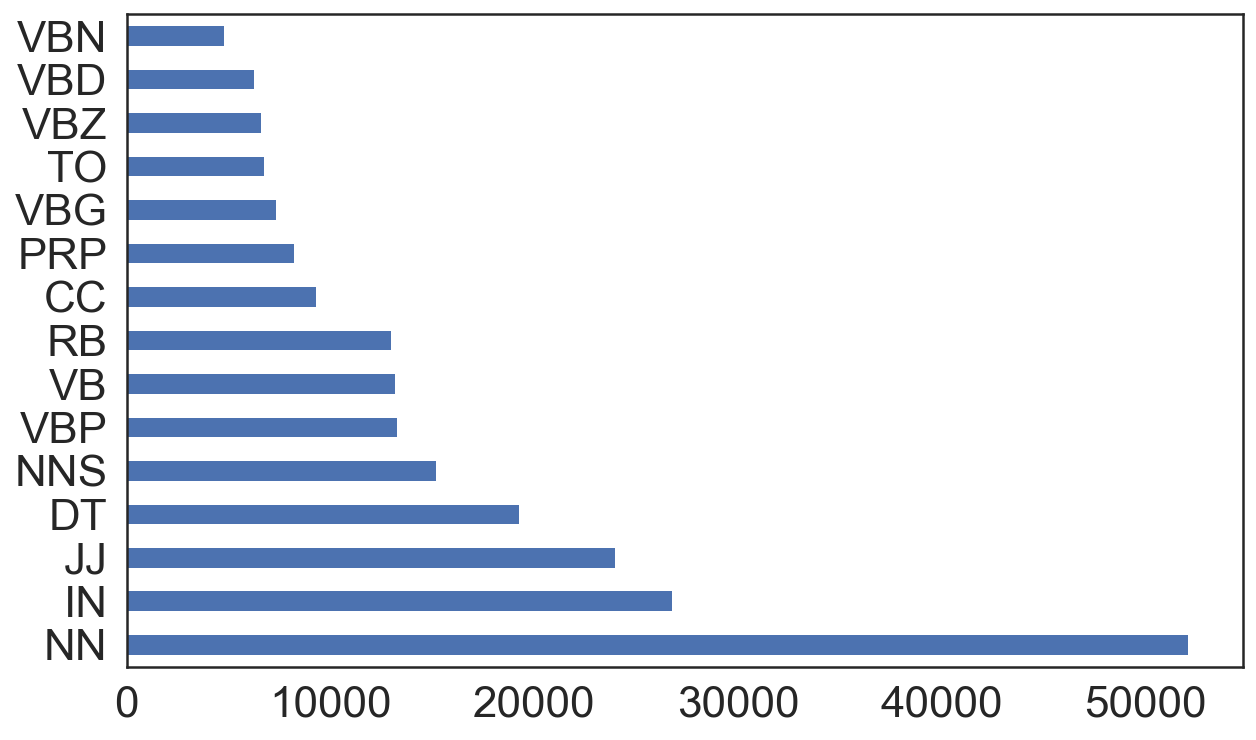

In [121]:
plt.figure(figsize=(10,6))

pos_df.sum().sort_values(ascending=False).head(15).plot(kind='barh');

# but I still did a plot, just to see

**Merge the origianl nutrituion/dietetic dataframe with tag dataframe**

In [122]:
nut_die_tag_df=pd.concat([nut_die,pos_df],axis=1)

In [123]:
nut_die_tag_df.shape

(3933, 40)

In [124]:
# the 15 most common tag for subreddit nutrition 

nut_die_tag_df.loc[nut_die_tag_df['nd_subreddit']==1].drop(columns='nd_title_text').sum().sort_values()[-20:-2]

MD               1407.0
VBN              1717.0
CD               1918.0
nd_subreddit     1953.0
TO               2097.0
VBD              2229.0
VBG              2365.0
PRP              2774.0
VBZ              2791.0
CC               3403.0
RB               4443.0
VBP              4466.0
VB               4522.0
NNS              6064.0
DT               6437.0
IN               9191.0
JJ               9256.0
NN              18973.0
dtype: float64

In [125]:
# the 15 most common tags for subreddit dietetics

nut_die_tag_df.loc[nut_die_tag_df['nd_subreddit']==0].drop(columns='nd_title_text').sum().sort_values()[-20:-2]

CD       2410.0
MD       2504.0
PRP$     3094.0
VBN      3128.0
VBZ      3856.0
VBD      4089.0
TO       4703.0
VBG      5022.0
PRP      5467.0
CC       5941.0
RB       8561.0
VB       8663.0
VBP      8855.0
NNS      9156.0
DT      12873.0
JJ      14733.0
IN      17580.0
NN      33094.0
dtype: float64